### Read in Libraries

In [60]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error


from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
from statsmodels.tsa.api import VAR

from fbprophet import Prophet
import plotly.express as px
from fbprophet.diagnostics import cross_validation, performance_metrics
from fbprophet.plot import plot_cross_validation_metric

### Read in the data

In [3]:
df = pd.read_csv('../../data/final_dfs/combined_final.csv')
temp_df = pd.read_csv('../../data/texas_temp.csv')

In [4]:
df.head()

,date,Biomass,Coal,Hydro,Nuclear,Other,Solar,Wind,NGas
0,2011-01-01,1240.848016,304483.8981,670.712237,90516.91023,357.449324,70.651290,123213.38820,248086.36399
1,2011-01-02,1478.590690,320703.6726,667.009668,90462.21494,372.626928,10.255158,62531.39844,268971.64998
2,2011-01-03,1483.246127,296436.2237,741.426017,90472.37075,401.536782,15.155827,89515.57352,222285.00985
3,2011-01-04,1411.010006,322214.6377,683.281626,90312.68708,478.415477,5.278214,59542.48570,271747.93685
4,2011-01-05,1348.331266,308136.0801,623.145421,90280.19160,440.383112,22.997359,128920.84250,358001.80005


In [5]:
df = df[['date', 'NGas']]

df['date']=pd.to_datetime(df['date'])

df = df[df['date'].dt.day == 1]

df.reset_index(inplace=True)

df.drop(columns='index',inplace=True)

df_full = pd.concat([df, temp_df], axis =1)

In [6]:
train_dates = pd.to_datetime(df['date'])
df_full.drop(columns='Date',inplace=True)
df_full.set_index('date', inplace=True)

<Figure size 1440x648 with 0 Axes>

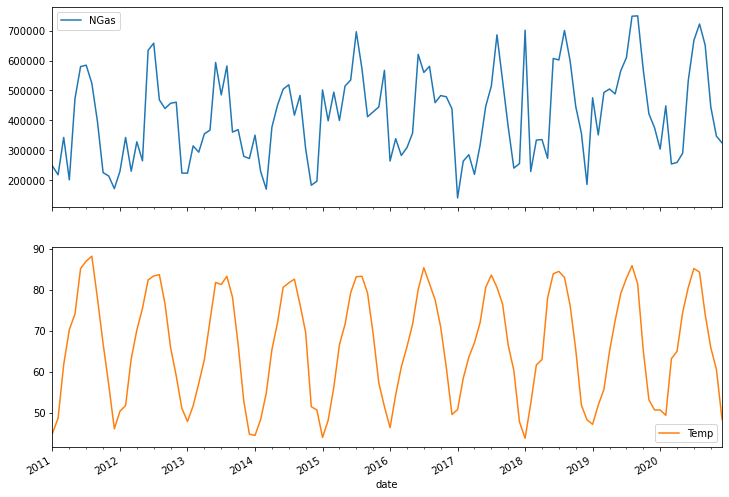

In [15]:
df_full.plot(subplots=True, figsize=(12,9));

In [21]:
df_full

,NGas,Temp
date,,
2011-01-01,248086.363990,45.0
2011-02-01,218819.159530,48.7
2011-03-01,343441.973030,61.8
2011-04-01,202053.382820,70.3
2011-05-01,472446.061500,74.1
...,...,...
2020-08-01,721716.604984,84.3
2020-09-01,651271.628603,74.0
2020-10-01,445206.272739,65.9


In [24]:
df_final=df_full.reset_index()[['date', 'NGas', 'Temp']].rename({'date':'ds','NGas':'y','Temp':'temp'},axis='columns')

In [25]:
df_final

,ds,y,temp
0,2011-01-01,248086.363990,45.0
1,2011-02-01,218819.159530,48.7
2,2011-03-01,343441.973030,61.8
3,2011-04-01,202053.382820,70.3
4,2011-05-01,472446.061500,74.1
...,...,...,...
115,2020-08-01,721716.604984,84.3
116,2020-09-01,651271.628603,74.0
117,2020-10-01,445206.272739,65.9
118,2020-11-01,347772.901358,60.6


In [27]:
df_final['month']=df_final['ds'].dt.month

In [35]:
df_final[['y', 'temp']].corr()

,y,temp
y,1.000000,0.634777
temp,0.634777,1.000000


In [45]:
train = df_final[(df_final['ds'] >= '2011-01-01') & (df_final['ds'] < '2020-01-01')]
test = df_final[(df_final['ds'] >= '2020-01-01')]

In [47]:
test

,ds,y,temp,month
108,2020-01-01,304592.954092,50.7,1
109,2020-02-01,448682.304718,49.4,2
110,2020-03-01,254899.753223,63.2,3
111,2020-04-01,259930.228185,65.0,4
112,2020-05-01,290880.811913,74.5,5
113,2020-06-01,533865.067901,80.6,6
114,2020-07-01,667294.351428,85.2,7
115,2020-08-01,721716.604984,84.3,8
116,2020-09-01,651271.628603,74.0,9
117,2020-10-01,445206.272739,65.9,10


In [48]:
m = Prophet(interval_width=0.95, yearly_seasonality=True)

In [49]:
m.fit(train)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [50]:
m.params

{'k': array([[0.18892982]]),
 'm': array([[0.46117191]]),
 'delta': array([[-3.42894731e-08, -1.24091531e-09, -9.67052068e-10,
         -1.08857285e-08, -2.55469086e-09, -4.78268566e-09,
         -1.27053920e-08, -2.21645625e-08,  4.64875443e-09,
         -4.64716336e-09, -2.70427715e-10,  4.33784307e-10,
          6.72041791e-09, -9.45889541e-09, -4.66005836e-09,
          6.53535610e-09,  5.19882603e-09,  2.65233269e-08,
          3.19873298e-09,  7.69928687e-06, -4.22027366e-10,
          3.07956837e-08, -2.56035356e-08, -4.46440306e-08,
         -7.96191619e-10]]),
 'sigma_obs': array([[0.12878124]]),
 'beta': array([[-3.14549905e-02, -1.79684453e-01,  4.08699555e-03,
          3.55581593e-02,  3.58583347e-03, -2.65772617e-03,
         -6.76516870e-03,  7.70933290e-03,  8.50599195e-03,
          1.38583425e-02, -5.34374130e-03, -8.19452592e-04,
          1.98504706e-03,  2.16943235e-02,  6.63331425e-03,
         -4.73950277e-05, -7.95134532e-03, -1.50878293e-03,
         -2.2500576

In [53]:
future = m.make_future_dataframe(periods=24, freq='MS')
future

,ds
0,2011-01-01
1,2011-02-01
2,2011-03-01
3,2011-04-01
4,2011-05-01
...,...
127,2021-08-01
128,2021-09-01
129,2021-10-01
130,2021-11-01


In [55]:
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
127,2021-08-01,682400.498186,502441.623602,863547.245729
128,2021-09-01,589791.392797,404974.342449,771544.049612
129,2021-10-01,504581.689105,326259.924629,681206.289349
130,2021-11-01,439355.651487,258957.937373,626562.757940
131,2021-12-01,394591.289460,205688.892497,604616.661578


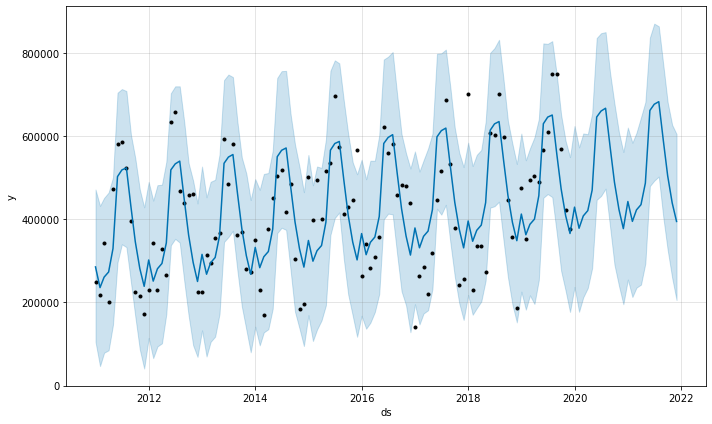

In [87]:
fig1 = m.plot(forecast)

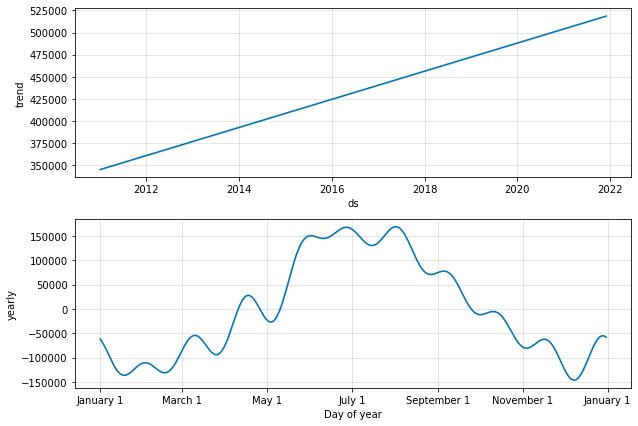

In [58]:
fig2 = m.plot_components(forecast)

### Cross Validation and Performance Metrics

In [72]:
cutoffs

DatetimeIndex(['2012-01-01', '2014-01-01', '2016-01-01', '2018-01-01'], dtype='datetime64[ns]', freq=None)

In [89]:
cv_results = cross_validation( model = m, initial = pd.to_timedelta(12,unit="M"), horizon = pd.to_timedelta(12,unit="M")

ValueError: Units 'M', 'Y', and 'y' are no longer supported, as they do not represent unambiguous timedelta values durations.

In [80]:
cutoffs = pd.to_datetime(df_final['ds'].tail(3).values)

In [82]:
cutoffs_1 = cutoffs[:-1]

In [92]:
cutoffs = pd.to_datetime(['2012-01-01', '2014-01-01', '2016-01-01'])
cv_results = cross_validation(model = m, cutoffs=cutoffs, horizon= '365 days')
df_p = performance_metrics(cv_results)
df_p

INFO:fbprophet:n_changepoints greater than number of observations. Using 9.


,horizon,mse,rmse,mae,mape,mdape,coverage
0,31 days,1.577276e+11,397149.340027,266940.067722,0.824791,0.425782,0.333333
1,59 days,1.150692e+11,339218.557390,235456.414565,0.886413,0.425782,0.222222
2,60 days,1.820349e+11,426655.457131,314197.259944,1.434523,1.009658,0.333333
3,90 days,1.747639e+11,418047.683015,286402.089508,1.176649,0.236037,0.666667
4,91 days,1.688669e+11,410934.210374,315224.576729,0.958040,0.554770,0.333333
5,120 days,1.662809e+11,407775.583847,290013.559190,0.889314,0.554770,0.333333
6,121 days,4.787773e+10,218809.805044,142739.029822,0.518472,0.105956,0.666667
7,151 days,5.252260e+10,229178.090341,177852.516128,0.587045,0.235577,0.333333
8,152 days,7.345343e+09,85704.976084,71604.189523,0.130001,0.142897,0.666667
9,181 days,5.241952e+09,72401.325408,61450.821675,0.108218,0.142897,1.000000


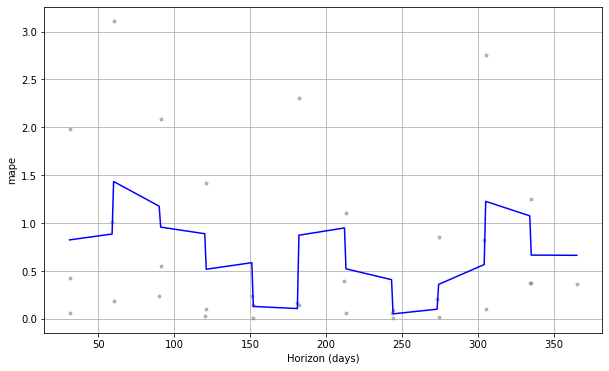

In [93]:
fig3 = plot_cross_validation_metric(cv_results, metric='mape')